In [0]:
filepath = 'brown_train.txt'

In [0]:
import matplotlib.pyplot as plt
import numpy as np


In [0]:
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
    
def load(filepath, window_size, vocab_size=None):

    words = []
    with open(filepath, 'r', encoding='utf8') as file:
        words = word_tokenize(file.readline())    

    x_train, y_train = [], []
    for i in range(len(words) - window_size + 1):
        x_train.append(words[i: i + window_size - 1])
        y_train.append(words[i +  window_size - 1])
    
    vocab = [word[0] for word in Counter(words).most_common(vocab_size)]
    word2id = { vocab[i]: i for i in range(len(vocab)) }
    
    return np.array(x_train), np.array(y_train)[:,None], np.array(vocab), word2id

def load_zh(filepath, window_size, vocab_size=None):

    words = []
    with open(filepath, 'r', encoding='utf8') as file:
        for line in file:
            words += word_tokenize(line.strip())
        

    x_train, y_train = [], []
    for i in range(len(words) - window_size + 1):
        x_train.append(words[i: i + window_size - 1])
        y_train.append(words[i +  window_size - 1])
    
    vocab = [word[0] for word in Counter(words).most_common(vocab_size)]
    word2id = { vocab[i]: i for i in range(len(vocab)) }
    
    return np.array(x_train), np.array(y_train)[:,None], np.array(vocab), word2id
            
def convert_to_id(x_train, y_train, vocab):
    
    word_to_id = {}
    for i, vocab in enumerate(vocab):
        word_to_id[vocab] = i
        
    for i in range(len(x_train)):
        x_train[i] = [word_to_id[word] for word in x_train[i]]
        y_train[i] = word_to_id[y_train[i][0]]
        
    return x_train.astype(int), y_train.astype(int)


def next_batch(x_train, y_train, batch_size):
    
    num_batch = len(x_train) // batch_size + 1
    for n in range(num_batch):        
        offset = n * batch_size
        x_batch = x_train[offset: offset + batch_size]
        y_batch = y_train[offset: offset + batch_size]
        
        yield x_batch, y_batch
        
# def convert_to_word(x_train, y_train, id_to_word):
#     for i in range(len(x_train)):
#         print(x_train[i])
#         x_train[i] = id_to_word[x_train[i]]
#         y_train[i] = id_to_word[y_train[i]]
#     return x_train, y_train

In [0]:
# hyperparameter
# TODO: change to number of batches 
batch_size = 30
# TODO: edit to be less hacky
window_size = 6
vocab_size = None
hidden_size = 50
emb_dim = 60
learning_rate = 0.3
epoch_size = 1

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# TODO: split into train, valid, test

In [15]:
x_raw, y_raw, vocab, word2id = load_zh(filepath, window_size, vocab_size)
vocab_size = len(vocab)
print('vocab_size: {}'.format(vocab_size))

vocab_size: 52945


In [0]:
filepath_v = 'brown_valid.txt'
x_raw_v, y_raw_v, vocab_v, word2id_v = load_zh(filepath_v, window_size, vocab_size)


In [10]:
vocab

array(['<', '>', 'the', ..., 'lurched', 'muddied', 'dogtrot'],
      dtype='<U38')

In [17]:
# integer representations of vocab
x_train, y_train = convert_to_id(x_raw, y_raw, vocab)
print('Length: {}'.format(len(x_train)))
print('Number of batch: {}'.format(len(x_train) / batch_size))

Length: 1321189
Number of batch: 44039.63333333333


In [18]:
x_valid, y_valid = convert_to_id(x_raw_v, y_raw_v, vocab_v)
print('Length: {}'.format(len(x_valid)))
print('Number of batch: {}'.format(len(x_valid) / batch_size))

Length: 175397
Number of batch: 5846.566666666667


In [13]:
x_train.shape

(1321189, 5)

In [19]:
# import tensorflow as tf
# %tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
# Model Parameter Definition


# Input && Output
input_words = tf.placeholder(dtype=tf.int32, shape=(batch_size, window_size-1))
output_word = tf.placeholder(dtype=tf.int32, shape=(batch_size, 1))


# Word Features
# word embedding matrix
# truncated_normal randomly initializes a matrix of the given shape with values from the normal distribution
C = tf.Variable(tf.truncated_normal(shape=(vocab_size, emb_dim), mean=-1, stddev=-1), name='word_embedding')


# Hidden Layer Weight && Bias
H = tf.Variable(tf.random_normal(shape=(hidden_size, (window_size - 1 ) * emb_dim)))
d = tf.Variable(tf.random_normal(shape=(hidden_size, )))

# Hidden-to-Output Weight && Bias
U = tf.Variable(tf.random_normal(shape=(vocab_size, hidden_size)))
b = tf.Variable(tf.random_normal(shape=(vocab_size, )))

# Projection-to-Output Weight
W = tf.Variable(tf.random_normal(shape=(vocab_size, (window_size - 1) * emb_dim)))

In [21]:
# y = b + Wx + Utanh(d + Hx)

# x = (C(w(t-1)), C(w(t-2), ..., C(w(t-n+1))), n == window_size
with tf.name_scope('Projection_Layer'):
  # get the actual embedding vectors from our batch inputs
    x  = tf.nn.embedding_lookup(C, input_words) # (batch_size, window_size-1, emb_dim)
    x  = tf.reshape(x, shape=(batch_size, (window_size - 1) * emb_dim))
    
with tf.name_scope('Hidden_Layer'):
    Hx = tf.matmul(x, tf.transpose(H)) # (batch_size, hidden_size)
    o  = tf.add(d, Hx) # (batch_size, hidden_size)
    a  = tf.nn.tanh(o)  # (batch_size, hidden_size)
     
with tf.name_scope('Output_Layer'):
    Ua = tf.matmul(a, tf.transpose(U)) # (batch_size, vocab_size)
    Wx = tf.matmul(x, tf.transpose(W)) # (batch_size, vocab_size)
    y  = tf.nn.softmax(tf.clip_by_value(tf.add(b, tf.add(Wx, Ua)), 0.0, 10)) # (batch_size, vocab_size)
    #ppl = -1*tf.log(y)

with tf.name_scope('Loss'):
    onehot_tgt = tf.one_hot(tf.squeeze(output_word), vocab_size)  # (batch_size, vocab_size)
    loss = -1 * tf.reduce_mean(tf.reduce_sum(tf.log(y) * onehot_tgt, 1)) # 乘 -1 -> maximize loss
   
with tf.name_scope('Perplexity'):
    ppl = tf.math.exp(loss)
    #print(ppl)
    
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss) 


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
from google.colab import drive
drive.mount('/content/gdrive/')

saver = tf.train.Saver()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [18]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True)) as sess:
    # initializes all of those variables we declared in earlier cells!
    initializer = tf.global_variables_initializer()
    initializer.run()
    
    step = 0
    avg_loss_t = 0
    avg_loss_v = 0
    loss_t = []
    loss_v = []
    saver.restore(sess, "/content/gdrive/My Drive/nnlm/final_model.ckpt")
    for epoch in range(epoch_size):
        print('epoch no ', epoch)
        save_path = saver.save(sess, "/content/gdrive/My Drive/nnlm/final_model.ckpt")

        for x_batch, y_batch in next_batch(x_train, y_train, batch_size):
            # if the batch is smaller than it's supposed to be (i.e. at end of vocab), skip it
            # TODO: change this to account for num_batches, not batch_size

            if len(x_batch) != batch_size:
                continue
            # give TF the data to use for all of the calcs in previous cells
            feed_dict = {input_words: x_batch, output_word: y_batch}
            # here we tell TF to return the loss to us 
            fetches = [loss, optimizer]
            # where the magic happens 
            Loss, _ = sess.run(fetches, feed_dict)
            avg_loss_t += Loss
            #ppl = Perplexity
            if step % 1000 == 0:
                print('Step {}, Loss: {}'.format(step, avg_loss_t / 1000))
                #print('Perplexity: {}'.format(ppl))

                for valid_x, valid_y in next_batch(x_valid, y_valid, batch_size):
                  if len(valid_x) != batch_size:
                    continue
                  feed_dict = {input_words: valid_x, output_word: valid_y}
                  fetches = [loss, optimizer]
                  Loss, _ = sess.run(fetches, feed_dict)
                  avg_loss_v += Loss
                print('Step {}, Loss: {}'.format(step, avg_loss_v / 1000))
                loss_t.append(avg_loss_t)
                loss_v.append(avg_loss_v)
                avg_loss_t = 0
                avg_loss_v = 0
                
            step += 1
        
    print('Training Done.')
    word_embedding = C.eval()
    # # TODO: this fails because it's a placeholder. Figure out how to visualize
    # # y 
    # y_vals = y.eval()
    
    

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/nnlm/final_model.ckpt
epoch no  0
Step 0, Loss: 0.008834031105041504
Step 0, Loss: 15.906856119394302
Step 1000, Loss: 6.618669257879257
Step 1000, Loss: 15.888002531528473
Step 2000, Loss: 6.350076826334
Step 2000, Loss: 15.876499027490615
Step 3000, Loss: 6.506515859127044
Step 3000, Loss: 15.867314840316773
Step 4000, Loss: 6.530137540340424
Step 4000, Loss: 15.868576750040054
Step 5000, Loss: 6.673533667325973
Step 5000, Loss: 15.866191981315612
Step 6000, Loss: 6.630266601800918
Step 6000, Loss: 15.862811940550804
Step 7000, Loss: 6.686098099470138
Step 7000, Loss: 15.863385906457902
Step 8000, Loss: 6.620896711587906
Step 8000,

In [0]:
# TODO: # y are our logits from the Bengio equation. those logits we must then convert to pseudo probabilities, then normalize via softmax to produce our y_hat.
#       y_hat should be (vocabulary length) X (1) in size

In [23]:
loss_t = np.array(loss_t)
plt.plot(range(len(loss_t)), np.exp(loss_t/1000))
loss_v = np.array(loss_v)
plt.plot(range(len(loss_v)), np.exp(loss_v/1000))
plt.show()

NameError: ignored

In [26]:
filepath_t = 'brown_test.txt'
x_raw_t, y_raw_t, vocab_t, word2id_t = load_zh(filepath_t, window_size, vocab_size)
x_test, y_test = convert_to_id(x_raw_t, y_raw_t, vocab_t)
print('Length: {}'.format(len(x_test)))
print('Number of batch: {}'.format(len(x_test) / batch_size))

Length: 189235
Number of batch: 6307.833333333333


In [32]:
avg_loss_test = 0
loss_test = []
ctr = 0
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True)) as sess:
  saver.restore(sess, "/content/gdrive/My Drive/nnlm/final_model.ckpt")
  step = 0
  for test_x, test_y in next_batch(x_test, y_test, batch_size):
    if len(test_x) != batch_size:
        continue
    feed_dict = {input_words: test_x, output_word: test_y}
    fetches = [loss, optimizer]
    # where the magic happens 
    Loss, _ = sess.run(fetches, feed_dict)
    avg_loss_test += Loss
    ctr += 1

    if step % 1000 == 0:
      print('Step {}, Loss: {}'.format(step, avg_loss_test / 1000))
      loss_test.append(avg_loss_test/1000)
      avg_loss_test = 0
    step += 1
#print(np.exp(avg_loss_test/ctr))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/nnlm/final_model.ckpt
Step 0, Loss: 0.008966852188110351
Step 1000, Loss: 9.015638908863068
Step 2000, Loss: 8.387402516841888
Step 3000, Loss: 8.1041927485466
Step 4000, Loss: 7.9367685546875
Step 5000, Loss: 7.894798601150513
Step 6000, Loss: 7.910759675502777


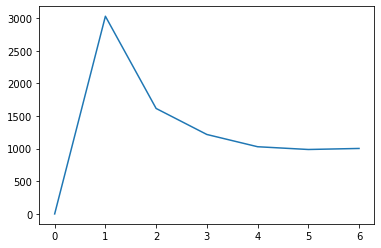

In [40]:
loss_test = np.array(loss_test)
plt.plot(range(len(loss_test)), np.exp(loss_test))
plt.show()


In [42]:
np.sum(np.exp(loss_test))/len(loss_test)

1268.636036360928